# Word similarity using word embeddings
+ gets word embeddings from [Glove](https://nlp.stanford.edu/projects/glove/)
+ tokenizes using nltk
+ extracts semantic features
+ cosine similarity
+ plots a similarity matrix

In [30]:
expression = """The Baroque style used contrast, movement, exuberant detail, deep colour, grandeur, and surprise to achieve a sense of awe."""
expression = """Among a sea of clouds, taking a deep breath, I am the wind."""
expression = """sea ship breath live eat vomit bite apple pear orange town country"""

In [37]:
# !pip install gensim

In [15]:
import re
import string

import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize as Tokenizer
# from nltk.tokenize import sent_tokenize, WhitespaceTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer

## Word embeddings 

In [4]:
import pickle
from pathlib import Path
pickle_file = Path('./OFFLINE', 'glove.6B.pickle')

def gensim_word_embeddings():
    with pickle_file.open('rb') as handle:
        word_embeddings = pickle.load(handle)
    print('loaded %s word vectors of %s dimensions.' % 
          (len(word_embeddings), len(next(iter(word_embeddings.values())))) )
    return word_embeddings          

In [5]:
word_embeddings = gensim_word_embeddings()

loaded 400000 word vectors of 100 dimensions.


## Features extraction

In [6]:
language='english'
stopwords_list = stopwords.words(language)
# token_classifier = PorterStemmer().stem
token_classifier = WordNetLemmatizer().lemmatize

In [7]:
def preprocessing(expression):
    expression = re.sub(r'\$\w*', '', expression)
    # remove hyperlinks
    expression = re.sub(r'https?://[^\s\n\r]+', '', expression)
    # remove hashtags: only removing the hash # sign from the word
    expression = re.sub(r'#', '', expression)
    return expression

In [8]:
def valid_semantic_feature(token):
     # remove isolated chars, stoptokens, punctuation
    return len(token) > 1 and token not in stopwords_list and token not in string.punctuation

In [9]:
def extract_semantic_features(expression):
    expression_tokens = Tokenizer(expression)
    expression_tokens = [token.lower() for token in expression_tokens]
    features = [token_classifier(token) 
                for token in expression_tokens
                if valid_semantic_feature(token)]
    return features

In [38]:
def extract_word_embeddings(expression):
    preprocessed = preprocessing(expression)
    semantic_features = extract_semantic_features(preprocessed)

    # word_embeddings
    feature_labels = [_ for _ in semantic_features if _ in word_embeddings]
    feature_labels_unmatched = [_ for _ in semantic_features if _ not in word_embeddings]
    print( len(semantic_features) - len(feature_labels), 'word(s) not found: ', ' '.join(feature_labels_unmatched))

    feature_vectors = [word_embeddings[_] for _ in feature_labels]
    return feature_labels, feature_vectors

In [39]:
feature_labels, feature_vectors = extract_word_embeddings(expression)
print(feature_labels)

1 word(s) not found:  sedqweda
['ship', 'breath', 'live', 'eat', 'vomit', 'bite', 'apple', 'pear', 'orange', 'town', 'country']


## Similarity

In [21]:
length = len(semantic_features)

matrix = np.zeros((length, length))
for i in range(length):
    for j in range(length):
#         print(feature_labels[i], feature_labels[j])
        A, B = feature_vectors[i], feature_vectors[j]
        similarity = np.dot(A,B) / (np.linalg.norm(A) * np.linalg.norm(B))
        matrix[i,j] = similarity
matrix.shape

(12, 12)

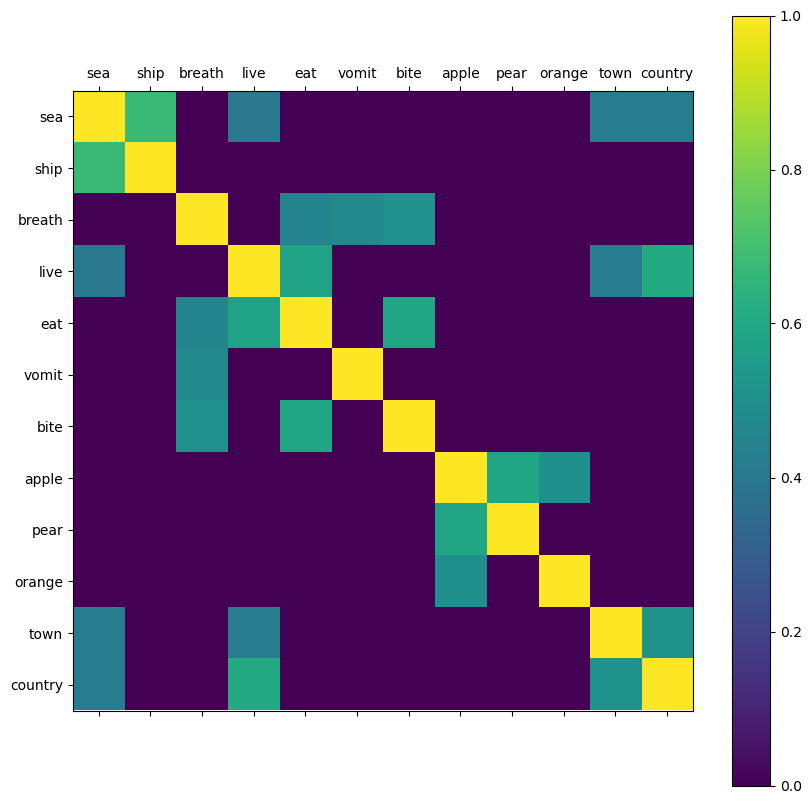

In [22]:
# calculate correlation between all columns
correlations = np.copy(matrix)
threshold = 0.4
correlations[correlations < threshold] = 0

# create a new figure
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
# normalize data using vmin, vmax
# cax = ax.matshow(data.corr(), vmin=-1, vmax=1)  # calculate correlation between all columns
cax = ax.matshow(correlations, vmin=0, vmax=1)
fig.colorbar(cax)

# define ticks
ticks = np.arange(length)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
# set x and y tick labels
ax.set_xticklabels(semantic_features)
ax.set_yticklabels(semantic_features)

plt.show()